Read section 3.2 of the book before using these notes.

Note: these notes focus on implementation. The book provides the conceptual explanations.


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

sns.set_theme(style="whitegrid", font_scale=1.2)

## Learning objectives

By the end of this notebook you should be able to:

- Fit a multiple linear regression model using `statsmodels` and `sklearn`.
- Interpret coefficients and overall model fit.
- Evaluate model performance on a held-out test set (RMSE, MAE, $R^2$).
- Explain why $R^2$ can increase when adding irrelevant predictors.


## Dataset

We will use the same dataset as SLR, specifically,

- Training set: `Datasets/Car_features_train.csv`, `Datasets/Car_prices_train.csv`
- Test set: `Datasets/Car_features_test.csv`, `Datasets/Car_prices_test.csv`

We will predict car price using `engineSize`, `age`, `mileage`, and `mpg`.


In [2]:
# Read training and test data
trainf = pd.read_csv('./Datasets/Car_features_train.csv')
trainp = pd.read_csv('./Datasets/Car_prices_train.csv')
train = pd.merge(trainf, trainp)

testf = pd.read_csv('./Datasets/Car_features_test.csv')
testp = pd.read_csv('./Datasets/Car_prices_test.csv')
test = pd.merge(testf, testp)

print('Train shape:', train.shape)
print('Test shape:', test.shape)
train.head()
# Create age feature using the most recent model year in the training data
reference_year = train["year"].max()
train["age"] = reference_year - train["year"]
test["age"] = reference_year - test["year"]


Train shape: (4960, 11)
Test shape: (2672, 11)


We convert model year to age using `reference_year = train["year"].max()`, then `age = reference_year - year`.
This anchors age to the most recent model year in the training set and keeps ages non-negative.


## Multiple Linear Regression

Instead of only using `engineSize`, we will use `age`, `mileage`, `mpg`, and `engineSize`.

### Training with `statsmodels` (formula API)

We fit an OLS model with a formula string.


In [3]:
# Fit multiple linear regression with statsmodels (formula API)
model_sm = smf.ols(
    formula='price ~ age + mileage + mpg + engineSize',
    data=train,
).fit()

model_sm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     2410.
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:40:20   Log-Likelihood:                -52497.
No. Observations:                4960   AIC:                         1.050e+05
Df Residuals:                    4955   BIC:                         1.050e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.102e+04    738.393     14.918      0.000    9567.676    1.25e+04
age        -1817.7366     73.751    -24.647      0.000   -1962.322   -1673.151
mileage       -0.1474      0.009    -16.817      0.000      -0.165      -0.130
mpg          -79.3126      9.338     -8.493      0.000     -97.620     -61.006
engineSize  1.218e+04    189.969     64.107      0.000    1.18e+04    1.26e+04
==============================================================================
Omnibus:                     2450.973   Durbin-Watson:                   0.541
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31060.548
Skew:                           2.045   Prob(JB):                         0.00
Kurtosis:                      14.557   Cond. No.                     1.94e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The fitted equation (from this dataset) is approximately:

$\hat{price}$ = b0 + b1 * `age` + b2 * `mileage` + b3 * `mpg` + b4 * `engineSize`

Interpretation: holding the other variables fixed, a one-unit increase in each predictor changes the expected price by its coefficient amount.


### Model Prediction and Error Metrics with `statsmodels`

Predict car prices for the test set.


In [4]:
pred_price_sm = model_sm.predict(test)

#Compute RMSE and MAE using NumPy (since statsmodels does not provide these metrics directly).
sm_rmse = np.sqrt(np.mean((testp.price - pred_price_sm) ** 2))
sm_mae = np.mean(np.abs(testp.price - pred_price_sm))
print(f'Statsmodels Test RMSE: ${sm_rmse:,.2f}')
print(f'Statsmodels Test MAE: ${sm_mae:,.2f}')


Statsmodels Test RMSE: $9,956.82
Statsmodels Test MAE: $6,407.74


### Training with `sklearn`

The procedure mirrors simple linear regression: prepare `X` and `y`, fit the model, and inspect coefficients.


In [5]:
# Prepare training data for sklearn
predictors = ["age", "mileage", "mpg", "engineSize"]
X_train = train[predictors]
y_train = train["price"]

model_skl = LinearRegression()
model_skl.fit(X_train, y_train)

coef_table = pd.Series(model_skl.coef_, index=predictors, name="coefficient")
print("Intercept:", model_skl.intercept_)
coef_table


Intercept: 11015.252952206762


age           -1817.736579
mileage          -0.147450
mpg             -79.312573
engineSize    12178.359942
Name: coefficient, dtype: float64

### Model Prediction and Error Metrics with `sklearn`

Predict on the test set and prepare metrics. Compute RMSE, MAE, and $R^2$ for train and test.


In [7]:
X_test = test[predictors]
y_test = test["price"]

y_pred_skl = model_skl.predict(X_test)
y_pred_train = model_skl.predict(X_train)

metrics = pd.DataFrame(
    {
        "Split": ["Train", "Test"],
        "RMSE": [
            root_mean_squared_error(y_train, y_pred_train),
            root_mean_squared_error(y_test, y_pred_skl),
        ],
        "MAE": [
            mean_absolute_error(y_train, y_pred_train),
            mean_absolute_error(y_test, y_pred_skl),
        ],
        "R2": [
            r2_score(y_train, y_pred_train),
            r2_score(y_test, y_pred_skl),
        ],
    }
)
metrics

,Split,RMSE,MAE,R2
0,Train,9558.926176,6292.020876,0.660482
1,Test,9956.824980,6407.739919,0.640127


### Diagnostics (test set)

Compare predicted vs actual prices. Perfect predictions lie on the line $y=x$.


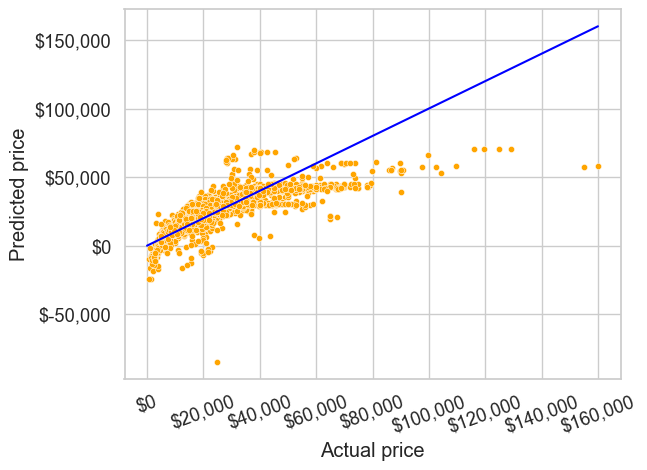

In [8]:
sns.scatterplot(x=y_test, y=y_pred_skl, color="orange", s=20)
ax = sns.lineplot(x=[0, y_test.max()], y=[0, y_test.max()], color="blue")
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.xaxis.set_major_formatter('${x:,.0f}')
plt.xticks(rotation=20);


## Effect of adding noisy predictors on $R^2$

Even a useless predictor can increase training $R^2$ because the model gains extra flexibility.


In [9]:
# Add a random predictor and refit with statsmodels
np.random.seed(1)
train = train.copy()
train["rand_col"] = np.random.rand(train.shape[0])

model_sm_noise = smf.ols(
    formula='price ~ age + mileage + mpg + engineSize + rand_col',
    data=train,
).fit()

print(f"Base model R2: {model_sm.rsquared:.4f}")
print(f"With random predictor R2: {model_sm_noise.rsquared:.4f}")


Base model R2: 0.6605
With random predictor R2: 0.6605


#### Same idea with `sklearn`

Compare training $R^2$ with and without the random predictor.


In [10]:
X_train_base = train[predictors]
X_train_noise = train[predictors + ["rand_col"]]

model_skl_base = LinearRegression().fit(X_train_base, y_train)
model_skl_noise = LinearRegression().fit(X_train_noise, y_train)

r2_base = r2_score(y_train, model_skl_base.predict(X_train_base))
r2_noise = r2_score(y_train, model_skl_noise.predict(X_train_noise))

pd.DataFrame(
    {
        "Model": ["Base predictors", "With random predictor"],
        "Train R2": [r2_base, r2_noise],
    }
)


,Model,Train R2
0,Base predictors,0.660482
1,With random predictor,0.660545


Adding noise can increase training $R^2$, but it does not guarantee better performance on new data. **Use validation or adjusted $R^2$ in MLR to guard against overfitting**.
